# B01: The Hilbert Transform (Quick Version)

**Duration**: ~30 minutes  
**Prerequisites**: A01, A02, A03, A04

> 💡 **Quick Version**: This notebook imports pre-built functions from `src/hilbert.py` instead of defining them inline. For the full tutorial with step-by-step function implementations, see [B01_hilbert_transform.ipynb](B01_hilbert_transform.ipynb).

## Learning Objectives

By the end of this notebook, you will be able to:
- Understand the analytic signal and its components
- Extract instantaneous amplitude (envelope) and phase from signals
- Apply the narrowband requirement for valid Hilbert analysis
- Use the functions from `src/hilbert.py`

---

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [The Analytic Signal](#section-2-analytic-signal)
3. [Extracting Envelope and Phase](#section-3-envelope-phase)
4. [The Narrowband Requirement](#section-4-narrowband)
5. [Complete EEG Workflow](#section-5-eeg-workflow)
6. [Exercises](#section-6-exercises)
7. [Summary](#summary)
8. [External Resources](#external-resources)
9. [Discussion Questions](#discussion-questions)

---

In [1]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# Local imports
src_path = Path.cwd().parent.parent.parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from hilbert import (
    compute_analytic_signal,
    compute_envelope,
    compute_instantaneous_phase,
    compute_instantaneous_frequency
)
from filtering import bandpass_filter
from colors import COLORS

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/src


---

<a id="section-1-introduction"></a>
## 1. Introduction

The **Hilbert transform** is a mathematical tool that converts a real signal into a **complex analytic signal**, from which we can extract:

- **Instantaneous amplitude (envelope)**: Signal strength over time
- **Instantaneous phase**: Position in the oscillatory cycle
- **Instantaneous frequency**: Rate of phase change

These quantities are essential for connectivity metrics like **PLV** (Phase Locking Value) and **Envelope Correlation**.

**Key requirement**: The signal must be **narrowband filtered** before applying the Hilbert transform for meaningful results.

---

<a id="section-2-analytic-signal"></a>
## 2. The Analytic Signal

The **analytic signal** is defined as:

$$z(t) = x(t) + i \cdot \mathcal{H}\{x(t)\}$$

Where $\mathcal{H}\{x(t)\}$ is the Hilbert transform, which shifts each frequency component by 90°.

From the analytic signal:
- **Envelope**: $A(t) = |z(t)|$
- **Phase**: $\phi(t) = \arg(z(t))$

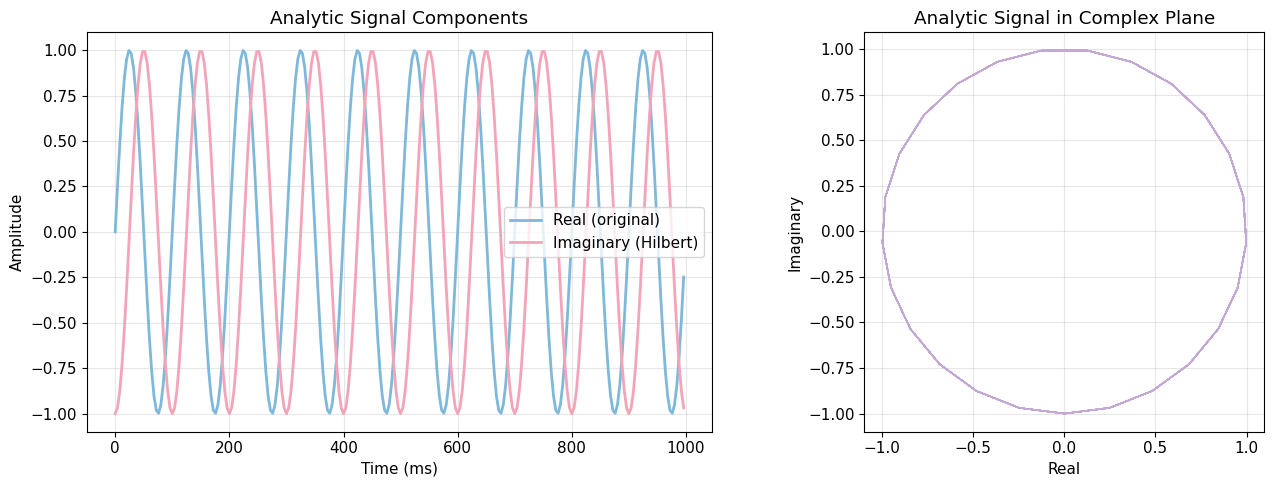

The analytic signal traces a circle in the complex plane.
The radius is the envelope, the angle is the phase.


In [2]:
# =============================================================================
# Section 2: The Analytic Signal
# =============================================================================

# Create a 10 Hz sine wave
fs = 250
duration = 1.0
t = np.arange(0, duration, 1/fs)
signal = np.sin(2 * np.pi * 10 * t)

# Compute analytic signal using imported function
analytic = compute_analytic_signal(signal)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time domain
axes[0].plot(t * 1000, np.real(analytic), color=COLORS["signal_1"], linewidth=2, label="Real (original)")
axes[0].plot(t * 1000, np.imag(analytic), color=COLORS["signal_2"], linewidth=2, label="Imaginary (Hilbert)")
axes[0].set_xlabel("Time (ms)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Analytic Signal Components")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Complex plane
axes[1].plot(np.real(analytic), np.imag(analytic), color=COLORS["signal_5"], linewidth=1)
axes[1].set_xlabel("Real")
axes[1].set_ylabel("Imaginary")
axes[1].set_title("Analytic Signal in Complex Plane")
axes[1].set_aspect("equal")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The analytic signal traces a circle in the complex plane.")
print("The radius is the envelope, the angle is the phase.")

---

<a id="section-3-envelope-phase"></a>
## 3. Extracting Envelope and Phase

Using the functions from `src/hilbert.py`:

- `compute_envelope(signal)` → Instantaneous amplitude
- `compute_instantaneous_phase(signal)` → Phase in radians [-π, π]

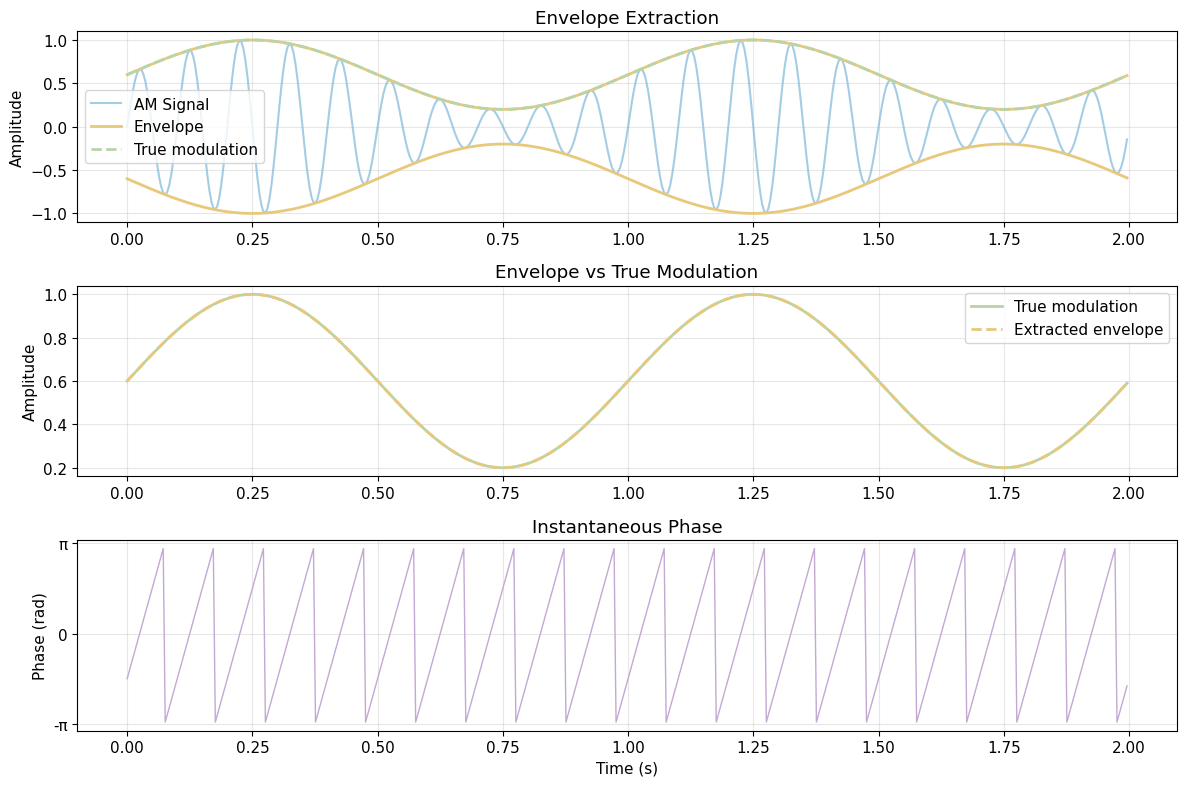

Correlation between true modulation and envelope: 1.0000


In [3]:
# =============================================================================
# Section 3: Extracting Envelope and Phase
# =============================================================================

# Create an amplitude-modulated signal
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Modulation: slow oscillation at 1 Hz
modulation = 0.6 + 0.4 * np.sin(2 * np.pi * 1 * t)

# Carrier: 10 Hz sine wave
carrier = np.sin(2 * np.pi * 10 * t)

# AM signal
am_signal = modulation * carrier

# Extract envelope and phase using imported functions
envelope = compute_envelope(am_signal)
phase = compute_instantaneous_phase(am_signal)

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Signal with envelope
axes[0].plot(t, am_signal, color=COLORS["signal_1"], alpha=0.7, label="AM Signal")
axes[0].plot(t, envelope, color=COLORS["signal_4"], linewidth=2, label="Envelope")
axes[0].plot(t, -envelope, color=COLORS["signal_4"], linewidth=2)
axes[0].plot(t, modulation, color=COLORS["signal_3"], linewidth=2, linestyle="--", label="True modulation")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Envelope Extraction")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Envelope comparison
axes[1].plot(t, modulation, color=COLORS["signal_3"], linewidth=2, label="True modulation")
axes[1].plot(t, envelope, color=COLORS["signal_4"], linewidth=2, linestyle="--", label="Extracted envelope")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Envelope vs True Modulation")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Phase
axes[2].plot(t, phase, color=COLORS["signal_5"], linewidth=1)
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Phase (rad)")
axes[2].set_title("Instantaneous Phase")
axes[2].set_yticks([-np.pi, 0, np.pi])
axes[2].set_yticklabels(["-π", "0", "π"])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation between true modulation and extracted envelope
correlation = np.corrcoef(modulation, envelope)[0, 1]
print(f"Correlation between true modulation and envelope: {correlation:.4f}")

---

<a id="section-4-narrowband"></a>
## 4. The Narrowband Requirement

**Critical**: The Hilbert transform only produces meaningful results for **narrowband signals**.

Rule of thumb: **Bandwidth / Center frequency < 0.5**

Examples:
- Alpha band (8-13 Hz): BW=5, fc=10.5 → ratio=0.48 ✓
- Broadband (1-50 Hz): BW=49, fc=25.5 → ratio=1.92 ✗

**Always filter first, then apply Hilbert transform!**

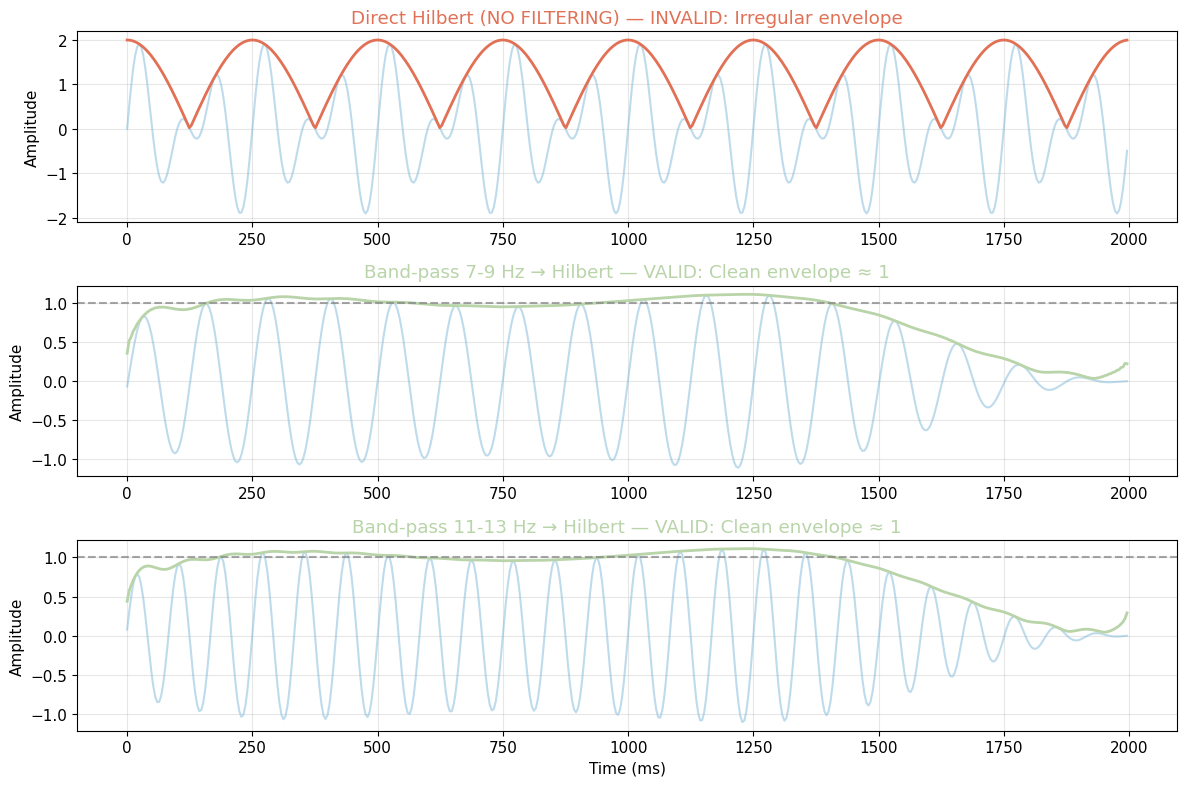

Conclusion: Without filtering, the envelope is meaningless.
After filtering to a narrow band, we get a clean, constant envelope.


In [4]:
# =============================================================================
# Section 4: The Narrowband Requirement
# =============================================================================

# Create a composite signal (8 Hz + 12 Hz)
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)

composite = np.sin(2 * np.pi * 8 * t) + np.sin(2 * np.pi * 12 * t)

# Direct Hilbert (INVALID - broadband)
envelope_direct = compute_envelope(composite)

# Filter then Hilbert (VALID - narrowband)
filtered_8hz = bandpass_filter(composite, 7, 9, fs)
envelope_8hz = compute_envelope(filtered_8hz)

filtered_12hz = bandpass_filter(composite, 11, 13, fs)
envelope_12hz = compute_envelope(filtered_12hz)

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Direct (invalid)
axes[0].plot(t * 1000, composite, color=COLORS["signal_1"], alpha=0.5)
axes[0].plot(t * 1000, envelope_direct, color=COLORS["negative"], linewidth=2)
axes[0].set_title("Direct Hilbert (NO FILTERING) — INVALID: Irregular envelope", color=COLORS["negative"])
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, alpha=0.3)

# 8 Hz filtered (valid)
axes[1].plot(t * 1000, filtered_8hz, color=COLORS["signal_1"], alpha=0.5)
axes[1].plot(t * 1000, envelope_8hz, color=COLORS["signal_3"], linewidth=2)
axes[1].axhline(y=1, color="gray", linestyle="--", alpha=0.7)
axes[1].set_title("Band-pass 7-9 Hz → Hilbert — VALID: Clean envelope ≈ 1", color=COLORS["signal_3"])
axes[1].set_ylabel("Amplitude")
axes[1].grid(True, alpha=0.3)

# 12 Hz filtered (valid)
axes[2].plot(t * 1000, filtered_12hz, color=COLORS["signal_1"], alpha=0.5)
axes[2].plot(t * 1000, envelope_12hz, color=COLORS["signal_3"], linewidth=2)
axes[2].axhline(y=1, color="gray", linestyle="--", alpha=0.7)
axes[2].set_title("Band-pass 11-13 Hz → Hilbert — VALID: Clean envelope ≈ 1", color=COLORS["signal_3"])
axes[2].set_xlabel("Time (ms)")
axes[2].set_ylabel("Amplitude")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Conclusion: Without filtering, the envelope is meaningless.")
print("After filtering to a narrow band, we get a clean, constant envelope.")

---

<a id="section-5-eeg-workflow"></a>
## 5. Complete EEG Workflow

A typical workflow for extracting alpha band dynamics from EEG:

1. **Band-pass filter** to alpha (8-13 Hz)
2. **Apply Hilbert transform** → analytic signal
3. **Extract envelope** (amplitude dynamics)
4. **Extract phase** (for connectivity metrics)

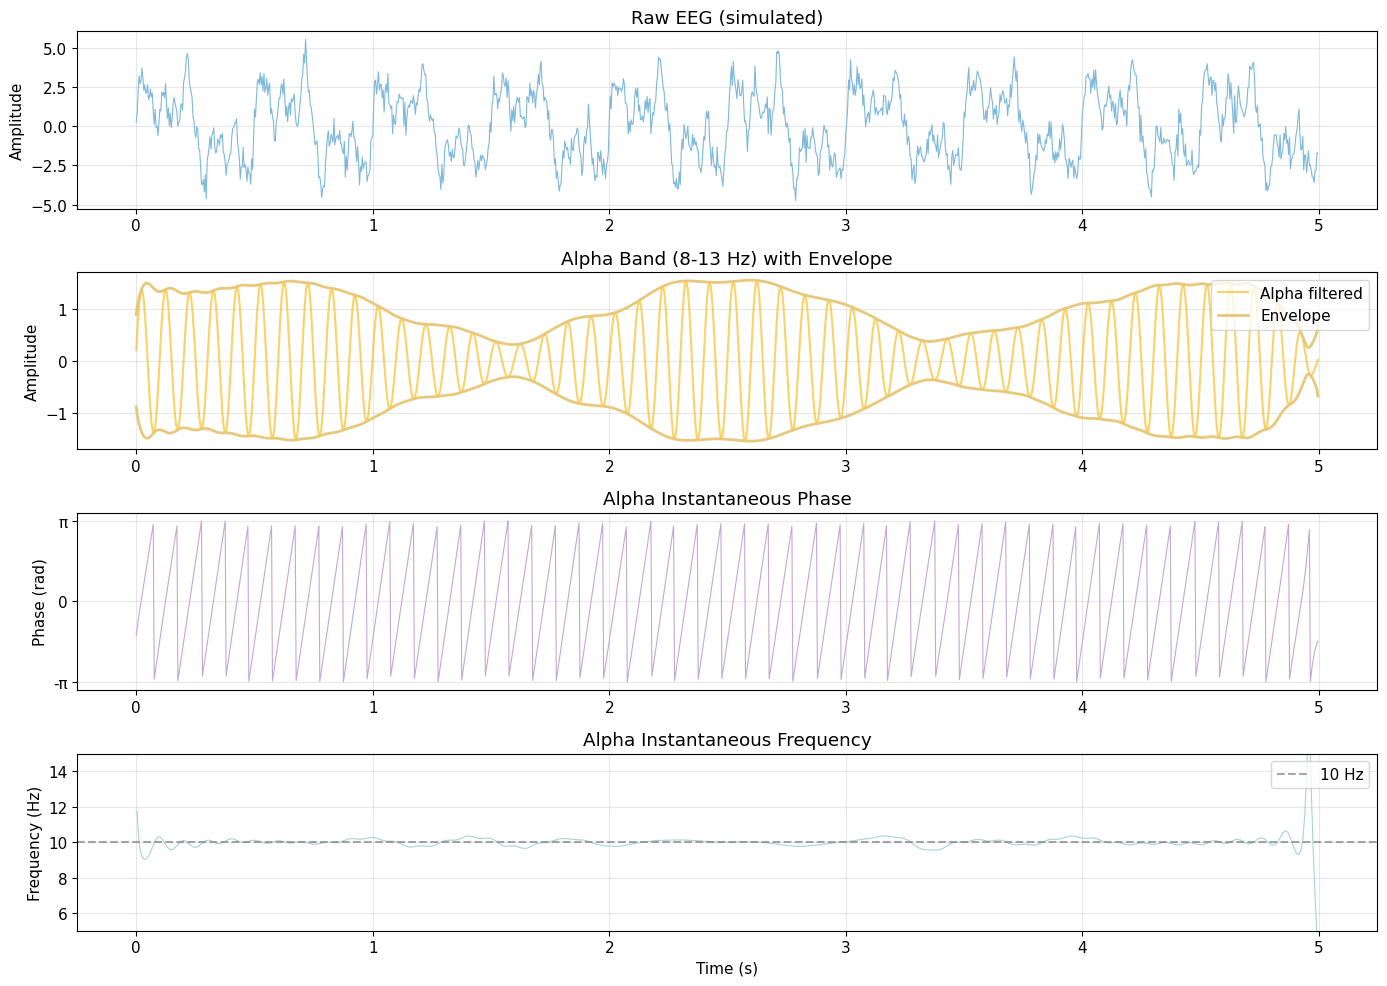

Mean alpha envelope: 1.057
Mean instantaneous frequency: 10.00 Hz


In [5]:
# =============================================================================
# Section 5: Complete EEG Workflow
# =============================================================================

# Simulate EEG-like signal
np.random.seed(42)
fs = 250
duration = 5.0
t = np.arange(0, duration, 1/fs)

# Multiple components + noise
delta = 2.0 * np.sin(2 * np.pi * 2 * t)  # Delta: 2 Hz
theta = 1.5 * np.sin(2 * np.pi * 6 * t)  # Theta: 6 Hz
alpha = (1 + 0.5 * np.sin(2 * np.pi * 0.5 * t)) * np.sin(2 * np.pi * 10 * t)  # Alpha with modulation
beta = 0.8 * np.sin(2 * np.pi * 20 * t)  # Beta: 20 Hz
noise = 0.5 * np.random.randn(len(t))

eeg = delta + theta + alpha + beta + noise

# Step 1: Band-pass filter to alpha
alpha_filtered = bandpass_filter(eeg, 8, 13, fs)

# Step 2-3: Extract envelope and phase
alpha_envelope = compute_envelope(alpha_filtered)
alpha_phase = compute_instantaneous_phase(alpha_filtered)
alpha_inst_freq = compute_instantaneous_frequency(alpha_filtered, fs)

# Visualize
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Raw EEG
axes[0].plot(t, eeg, color=COLORS["signal_1"], linewidth=0.8)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Raw EEG (simulated)")
axes[0].grid(True, alpha=0.3)

# Filtered alpha with envelope
axes[1].plot(t, alpha_filtered, color=COLORS["alpha"], alpha=0.6, label="Alpha filtered")
axes[1].plot(t, alpha_envelope, color=COLORS["signal_4"], linewidth=2, label="Envelope")
axes[1].plot(t, -alpha_envelope, color=COLORS["signal_4"], linewidth=2)
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Alpha Band (8-13 Hz) with Envelope")
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)

# Phase
axes[2].plot(t, alpha_phase, color=COLORS["signal_5"], linewidth=0.8)
axes[2].set_ylabel("Phase (rad)")
axes[2].set_title("Alpha Instantaneous Phase")
axes[2].set_yticks([-np.pi, 0, np.pi])
axes[2].set_yticklabels(["-π", "0", "π"])
axes[2].grid(True, alpha=0.3)

# Instantaneous frequency
axes[3].plot(t, alpha_inst_freq, color=COLORS["signal_6"], linewidth=0.8)
axes[3].axhline(y=10, color="gray", linestyle="--", alpha=0.7, label="10 Hz")
axes[3].set_xlabel("Time (s)")
axes[3].set_ylabel("Frequency (Hz)")
axes[3].set_title("Alpha Instantaneous Frequency")
axes[3].set_ylim(5, 15)
axes[3].legend(loc="upper right")
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean alpha envelope: {np.mean(alpha_envelope):.3f}")
print(f"Mean instantaneous frequency: {np.mean(alpha_inst_freq):.2f} Hz")

---

<a id="section-6-exercises"></a>
## 6. Exercises

### 🎯 Exercise 1: Phase Difference Analysis

**Task:** Create two 10 Hz sine waves with a 90° phase difference. Extract their phases using the Hilbert transform and verify the phase difference is constant at π/2.

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Create two signals with 90° phase difference
signal1 = np.sin(2 * np.pi * 10 * t)
signal2 = np.sin(2 * np.pi * 10 * t + np.pi/2)

# Extract phases
phase1 = compute_instantaneous_phase(signal1)
phase2 = compute_instantaneous_phase(signal2)

# Compute phase difference (circular)
phase_diff = np.angle(np.exp(1j * (phase2 - phase1)))

print(f"Mean phase difference: {np.mean(phase_diff):.4f} rad (expected: {np.pi/2:.4f})")
```

</details>

### 🎯 Exercise 2: Theta Band Analysis

**Task:** Using the simulated EEG from Section 5, extract the theta band (4-8 Hz) envelope. Compare its dynamics to the alpha envelope.

```python
# Your code here
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Filter to theta band
theta_filtered = bandpass_filter(eeg, 4, 8, fs)

# Extract envelope
theta_envelope = compute_envelope(theta_filtered)

# Compare with alpha
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t, alpha_envelope, color=COLORS["alpha"], label="Alpha envelope")
ax.plot(t, theta_envelope, color=COLORS["theta"], label="Theta envelope")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Envelope")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
```

</details>

---

<a id="summary"></a>
## 7. Summary

### Key Concepts

| Concept | Definition |
|---------|------------|
| **Analytic Signal** | $z(t) = x(t) + i\hat{x}(t)$ — complex signal with Hilbert transform as imaginary part |
| **Envelope** | $A(t) = |z(t)|$ — instantaneous amplitude |
| **Phase** | $\phi(t) = \arg(z(t))$ — instantaneous phase |
| **Instantaneous Frequency** | $f(t) = \frac{1}{2\pi}\frac{d\phi}{dt}$ — rate of phase change |

### Complete Workflow

```python
# 1. Filter to narrowband
filtered = bandpass_filter(signal, low, high, fs)

# 2. Extract envelope and phase
envelope = compute_envelope(filtered)
phase = compute_instantaneous_phase(filtered)
```

### Key Warnings

1. **Narrowband requirement**: Always filter before Hilbert transform
2. **Edge effects**: Trim signal edges after filtering
3. **Phase reliability**: Phase is only meaningful when amplitude is sufficient

---

<a id="external-resources"></a>
## 8. External Resources

### 🎧 NotebookLM Resources

- [📺 Video Overview](https://notebooklm.google.com/notebook/b9f2793f-11d9-410c-999d-00aada445602?artifactId=f884cad7-8611-4527-9648-75e2a22ff151) - Video overview of Hilbert transform concepts
- [📝 Quiz](https://notebooklm.google.com/notebook/b9f2793f-11d9-410c-999d-00aada445602?artifactId=818bfae9-c00e-416a-aa7f-5bd70211ea94) - Test your understanding
- [🗂️ Flashcards](https://notebooklm.google.com/notebook/b9f2793f-11d9-410c-999d-00aada445602?artifactId=dc2a4e04-8bec-459d-ad5a-3c5f82947566) - Review key concepts

---

<a id="discussion-questions"></a>
## 9. Discussion Questions

1. **Narrowband Trade-off**: If you want to analyze theta (4-8 Hz) and alpha (8-13 Hz) together, what are your options? What are the trade-offs?

2. **Phase Reliability**: How would you determine if the instantaneous phase is reliable at a given time point?

3. **Edge Effects**: In a hyperscanning experiment with 30-second epochs, how much data should you discard from each end when analyzing alpha band?

---

## Next Steps

- **B02**: Working with Phase (unwrapping, circular statistics)
- **B03**: Amplitude Envelope applications
- **B04**: Wavelet-based time-frequency analysis